# Multi-band fitting
This notebook provides the basics for multi-band fitting with lenstronomy. The example chosen is from the 'simple Einstein ring' example. The multi-band aspects discribed in this notebook can also be used for any other usecase of lenstronomy.


## Multi-band basics
Conceptually, multiple exposures or filters effectively is an extension of the data vector. Each individual band comes with it's own noise properties, PSF, coordination system and pixel scale. In lenstronomy we effectively append an arbitrary length of bands in the multi_band_list argument of the fitting sequence. That's it!

The more subtle part comes with the modeling assumptions to be made. There are two main options to distinguis: multi-linear and joint-linear.

multi-linear: Though the model components (or a subset) are shared with the different bands, the amplitude of the linear surface brightness components are not shared and the linear inversion is done band-by-band independently. If you have different wavelength observations, this allows for the flexibility of different colors (ratios of fluxes between different bands) and surface brightness morphology.

You have also the option with this mode/class to use different non-linear light profiles for different bands. The class supports keyword arguments 'index_lens_model_list', 'index_source_light_model_list',
    'index_lens_light_model_list', 'index_point_source_model_list', 'index_optical_depth_model_list' in kwargs_model
These arguments should be lists of length the number of imaging bands available and each entry in the list is a list of integers specifying the model components being evaluated for the specific band.

E.g. there are two bands and you want to different light profiles being modeled.
    - you define two different light profiles lens_light_model_list = ['SERSIC', 'SERSIC']
    - set index_lens_light_model_list = [[0], [1]]
    - (optional) for now all the parameters between the two light profiles are independent in the model. You have the possibility to join a subset of model parameters (e.g. joint centroid). See the Param() class for documentation.


joint-linear: Only one linear inversion is performed demanding that all amplitude coefficients are shared. This modeling demands an identical intrinsic model (modulo observational conditions) for all exposures. This can be a good approximation for a time-static object with multiple exposures of one single wavelength band.

You can also use this mode to model different patches within one model simultaneously (multiple smaller cutouts of the same image where relevant for the model, to avoid a too large data vector). This can be helpful in the cluster regime. You have also the option in this mode to change the lens model (only do so when you know what you are doing) for the individual cutous to infer relative lensing operators.

## General recommendations

Here a few general recommenation that may help in the modeling of multi-band data.
- Start simple: It is relatively easy to become overwhelmed with complexity, handling of parameters, convergence and computational cost when adding multiple bands. Lenstronomy allows (too) conveniently to add multiple data and extend the modeling features. So start simple and explore the need for adding modeling complexity as you progress.
- Start only with one band (preferentially the most informative one): Having a model of one band can help in the decision and usage of subsequent data. This also helps to start simple. The fitting sequence allows you to make one instance for all bands and then first only chose a subset of bands to be modeled. This may also help in the convergence of you model.
- Be aware of astrometric misalignment: Even minor misalignment in the relative coordinate system between two or more bands may result in significant residual biases. It is important to have the images aligned to very high precision. The lenstronomy fitting sequence has an option 'align_images()' which allows, for a given model (say fit with one band only), to fit for potential alignment offset between the images and then use the updated coordinate system for further modeling.

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import copy
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

Here we chose two different imaging bands with different observational and noise properties. We also perform an arbitrary misalignment in the coordinate grid between the two imaging bands as perfect alignment is hard to achieve and to demonstrate the alignment feature in lenstronomy.

In [2]:
# ==========================
# data specifics for image 1
# ==========================
background_rms1 = .005  #  background noise per pixel
exp_time1 = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix1 = 60  #  cutout pixel size
deltaPix1 = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm1 = 0.05  # full width half max of PSF
psf_type1 = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'


# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix1, deltapix=deltaPix1, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data1 = {'background_rms': background_rms1,  # rms of background noise
               'exposure_time': exp_time1,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix1, numPix1))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

# generate the psf variables
kwargs_psf1 = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm1, 'pixel_size': deltaPix1, 'truncation': 3}

kwargs_numerics1 = {'supersampling_factor': 1, 'supersampling_convolution': False}

# ==========================================================================================


# ==========================
# data specifics for image 2
# ==========================
background_rms2 = .01  #  background noise per pixel
exp_time2 = 200.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix2 = 30  #  cutout pixel size
deltaPix2 = 0.1  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm2 = 0.2  # full width half max of PSF
psf_type2 = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'


# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix2, deltapix=deltaPix2, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)



kwargs_data2 = {'background_rms': background_rms2,  # rms of background noise
               'exposure_time': exp_time2,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0 - 0.1,  # RA at (0,0) pixel  HERE WE SET AN OFFSET BETWEEN THE IMAGES - BECAUSE WE CAN!
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix2, numPix2))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

# generate the psf variables
kwargs_psf2 = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm2, 'pixel_size': deltaPix2, 'truncation': 3}

# we used larger pixel sizes for image 2 so to get to the same ray tracing resolution (numerics, we need super-sampling)
kwargs_numerics2 = {'supersampling_factor': 2, 'supersampling_convolution': False}  


# ==============================================================================================

# this is the list of data properties (without the actual simulated data yet)
multi_band_list_sim = [[kwargs_data1, kwargs_psf1, kwargs_numerics1], [kwargs_data2, kwargs_psf2, kwargs_numerics2]]


In [3]:


# lensing quantities (applicable for both bands)
lens_model_list = ['SIE', 'SHEAR']
kwargs_sie = {'theta_E': .66, 'center_x': 0.05, 'center_y': 0, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_lens = [kwargs_sie, kwargs_shear]


# Sersic parameters in the initial simulation for the source. Here we use two different Sersic profiles for the two bands to describe a morphology difference
kwargs_sersic1 = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
kwargs_sersic2 = {'amp': 30, 'R_sersic': 0.2, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}

source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic1, kwargs_sersic2]
index_source_light_model_list = [[0], [1]]  # set the first model to data1 and second model to data2

# for this example we chose the identical model for the lens light profile for simplicity.
kwargs_sersic_lens = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]


kwargs_model = {'lens_model_list': lens_model_list, 
                'source_light_model_list': source_model_list, 
                'lens_light_model_list': lens_light_model_list,
                'index_source_light_model_list': index_source_light_model_list
               }

### Simulate images with noise

Here we simulate the two bands, using the SingleBandMultiModel() class, which allows to select a subset of the full models to be used for individual bands

In [4]:


from lenstronomy.ImSim.MultiBand.single_band_multi_model import SingleBandMultiModel

# making two instances of ImageModel that allow the evaluation of a subset of the model components and indicating which band to be evaluated.
sim_band1 = SingleBandMultiModel(multi_band_list=multi_band_list_sim, kwargs_model=kwargs_model, likelihood_mask_list=None, band_index=0)
sim_band2 = SingleBandMultiModel(multi_band_list=multi_band_list_sim, kwargs_model=kwargs_model, likelihood_mask_list=None, band_index=1)


# generate image
image_model1 = sim_band1.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
image_model2 = sim_band2.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

import lenstronomy.Util.image_util as image_util
poisson1 = image_util.add_poisson(image_model1, exp_time=exp_time1)
bkg1 = image_util.add_background(image_model1, sigma_bkd=background_rms1)
image_real1 = image_model1 + poisson1 + bkg1
kwargs_data1['image_data'] = image_real1

poisson2 = image_util.add_poisson(image_model2, exp_time=exp_time2)
bkg2 = image_util.add_background(image_model2, sigma_bkd=background_rms2)
image_real2 = image_model2 + poisson2 + bkg2
kwargs_data2['image_data'] = image_real2


/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_4767/2266627457.py:14: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real1), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_4767/2266627457.py:20: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real2), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


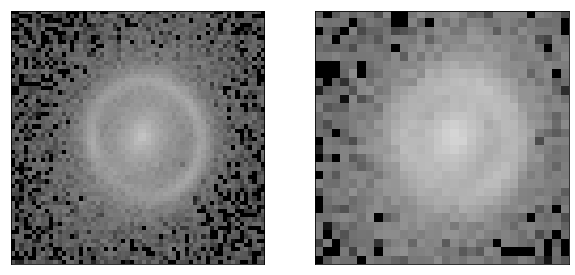

In [5]:
# display the initial simulated image

cmap = mpl.cm.get_cmap("gray").copy()
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes[0]
im = ax.matshow(np.log10(image_real1), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
im = ax.matshow(np.log10(image_real2), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

### introduce systematic misalignment between the two coordinate grids
The images were simulated relative to the same coordinate grid and all the lens and light model components are expected to be recovered acurately for both images consistently. However, in real life, perfect relative coordinate alignment is very hard to achieve. Here we offset the coordinate grid of the second image systematically. We elaborate in the fitting how we can re-align the astrometry of the two images.

In [6]:
kwargs_data2_offset = copy.deepcopy(kwargs_data2)
kwargs_data2_offset['ra_at_xy_0'] += 0.083
kwargs_data2_offset['dec_at_xy_0'] -= 0.019


multi_band_list = [[kwargs_data1, kwargs_psf1, kwargs_numerics1], [kwargs_data2_offset, kwargs_psf2, kwargs_numerics2]]

## Model fitting
in the blocks above we simulated a mock lens with noise properties. From these cells, we only require the kwargs_data and kwargs_psf arguments to perform the modeling. If you have real data, you can leave out the image simulation and directly read in the data, PSF and noise properties into the keyword arguement list. Make sure the units are correct. Further information on the settings are available in the ImageData() and PSF() classes in the lenstronomy.Data module.

In [7]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 0.7, 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# we have two source models
fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0.3, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 2, 'e1': 0.3, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


In [8]:
kwargs_likelihood = {'source_marg': False,
                    'bands_compute': [True, True],  # (optional) you can select a specific sub-set of imaging band to be modeled and update it during different steps of the fitting sequence
                    }

kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }


#    'joint_source_with_source':list [[i_source, k_source, ['param_name1', 'param_name2', ...]], [...], ...],
#    joint parameter between two source surface brightness models, the second adopts the value of the first

# here we add (optional) constraints between the light profile of the two different imaging bands. We demand the center ellipticity to be the same.
# effectively this leaves the half-light radius and Sersic index free between the colors.
kwargs_constraints = {'joint_source_with_source': [[0, 1, ['center_x', 'center_y', 'e1', 'e2']]]}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False]},  # only compute first band
                        'source_add_fixed': [[1, ['R_sersic', 'n_sersic', 'e1', 'e2']]]  # fix all parameters that are only used in the second band
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],  # run PSO first band
    ['align_images', {'n_particles': 10, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': 0.2, 'delta_rot': 0.1,
                      'compute_bands': [False, True]}],  # align second image
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True]},  # now we fit both bands jointly
                        'source_remove_fixed': [[1, ['R_sersic', 'n_sersic', 'e1', 'e2']]]  # and release all parameters of the second band to be free
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],  # run PSO of both bands
    ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}]  # run MCMC for all parameters
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.029890175922386 reduced X^2 of best position
-1842.9884698131095 log likelihood
3579 effective number of data points
[{'theta_E': 0.6598777393894442, 'e1': 0.0641515484510663, 'e2': -0.018992896634537647, 'center_x': 0.04822724349929587, 'center_y': 0.001513871875816641}, {'gamma1': -0.0019209202709304341, 'gamma2': -0.04383603839660495, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09769729191009147, 'n_sersic': 0.9595305156877248, 'e1': -0.09342215508512985, 'e2': 0.09034139784459488, 'center_x': 0.10105980695803943, 'center_y': -0.0005120541344538175}, {'amp': 1, 'R_sersic': 0.2, 'n_sersic': 2, 'e1': -0.09342215508512985, 'e2': 0.09034139784459488, 'center_x': 0.10105980695803943, 'center_y': -0.0005120541344538175}] source result
[{'amp': 1, 'R_sersic': 0.6324886118876675, 'n_sersic': 2.0877823023596735, 'e1': -0.1029250272191657, 'e2': 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.12it/s]

Computing the MCMC...
Number of walkers =  210
Burn-in iterations:  100
Sampling iterations (in current run): 200
64.47179794311523 time taken for MCMC sampling


## analyse MCMC chain

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


-1.0289985049105501 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.025186257030201
reduced chi^2 of data  1 =  1.044247496431947


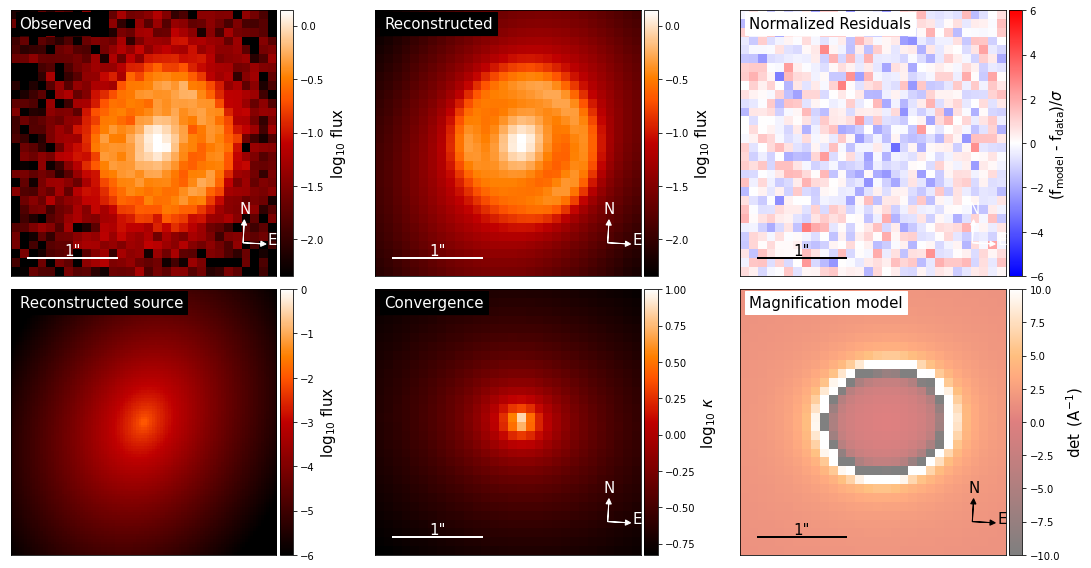

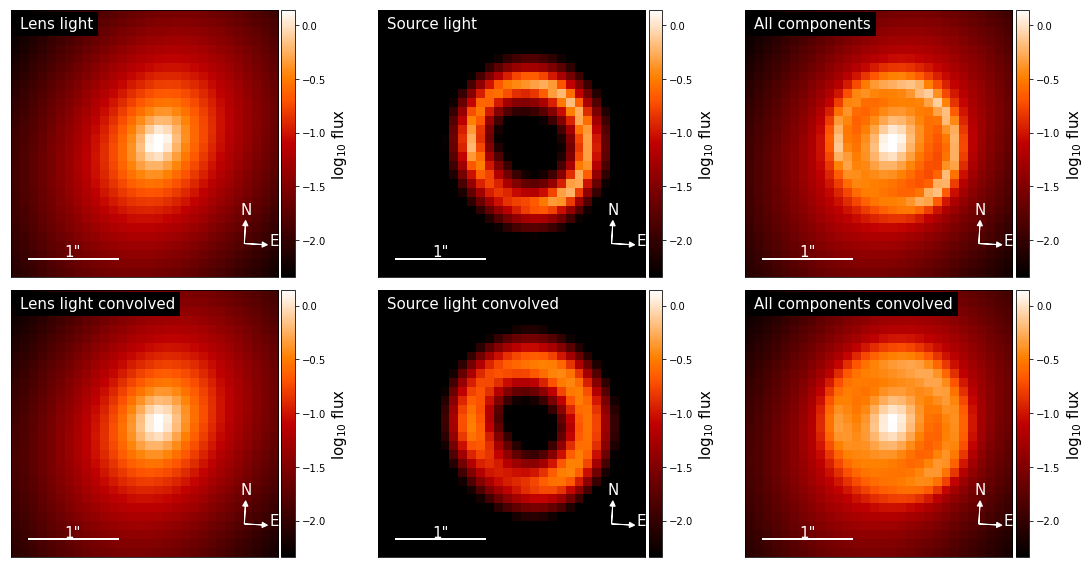

{'kwargs_lens': [{'theta_E': 0.6596205376307134, 'e1': 0.06761844011855411, 'e2': -0.01928300601052024, 'center_x': 0.0469951522420967, 'center_y': 0.004079715766773183}, {'gamma1': 0.0006196117480811115, 'gamma2': -0.04590883557719981, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.09990834612988615, 'n_sersic': 0.9847850209472115, 'e1': -0.10604050394835038, 'e2': 0.0853278517202089, 'center_x': 0.10069637860688117, 'center_y': 0.001293395647442588}, {'amp': 1, 'R_sersic': 0.10287830283247956, 'n_sersic': 1.2976822461221065, 'e1': -0.10604050394835038, 'e2': 0.0853278517202089, 'center_x': 0.10069637860688117, 'center_y': 0.001293395647442588}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.625280603476154, 'n_sersic': 2.0946822978704396, 'e1': -0.1026268475493373, 'e2': 0.0913001159146306, 'center_x': 0.05233251230421466, 'center_y': 0.003925553772428336}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [9]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# here you can choose which band to be plotted
band_index_plot = 1  # chose either 0 or 1 for this example


f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], band_index=band_index_plot)
modelPlot.model_plot(ax=axes[0,1], band_index=band_index_plot)
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_index_plot)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,  v_min=-6, v_max=0, band_index=band_index_plot)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_index_plot)
modelPlot.magnification_plot(ax=axes[1, 2], band_index=band_index_plot)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], band_index=band_index_plot, text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], band_index=band_index_plot, text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], band_index=band_index_plot, text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], band_index=band_index_plot, text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], band_index=band_index_plot, text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], band_index=band_index_plot, text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  21
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_source_light1', 'n_sersic_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  21000
21000


/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_4767/545214015.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


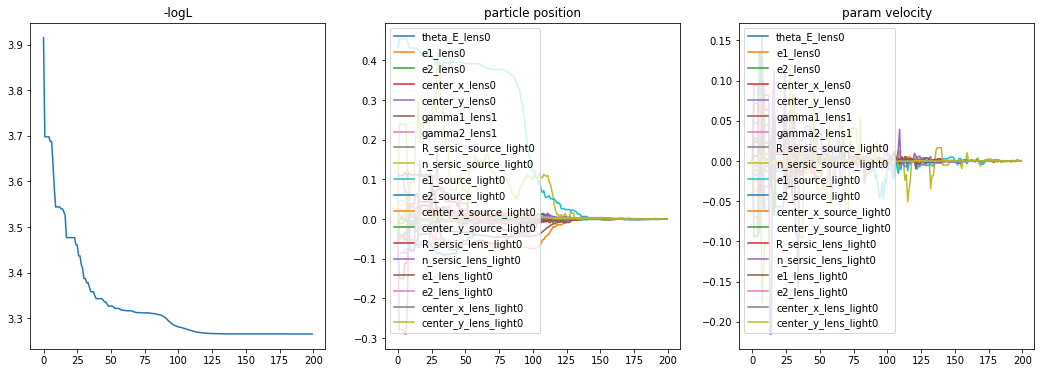

<Figure size 432x288 with 0 Axes>

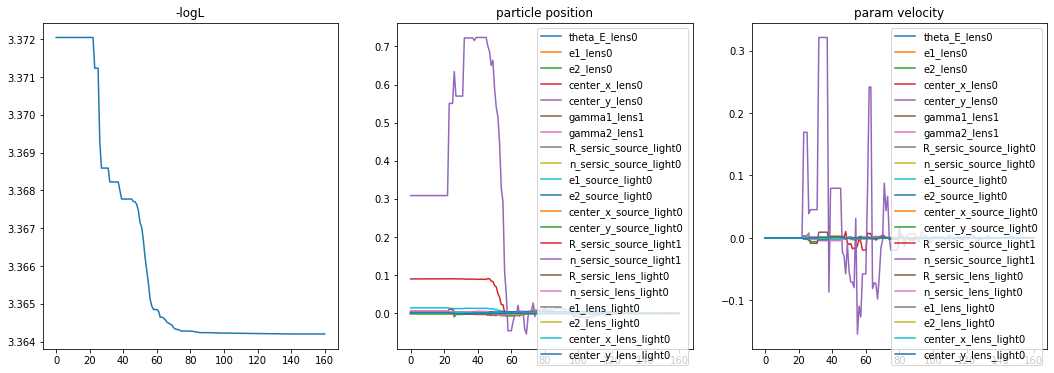

<Figure size 432x288 with 0 Axes>

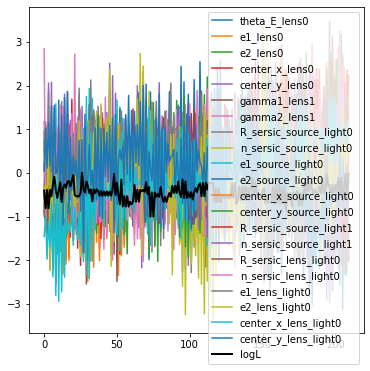

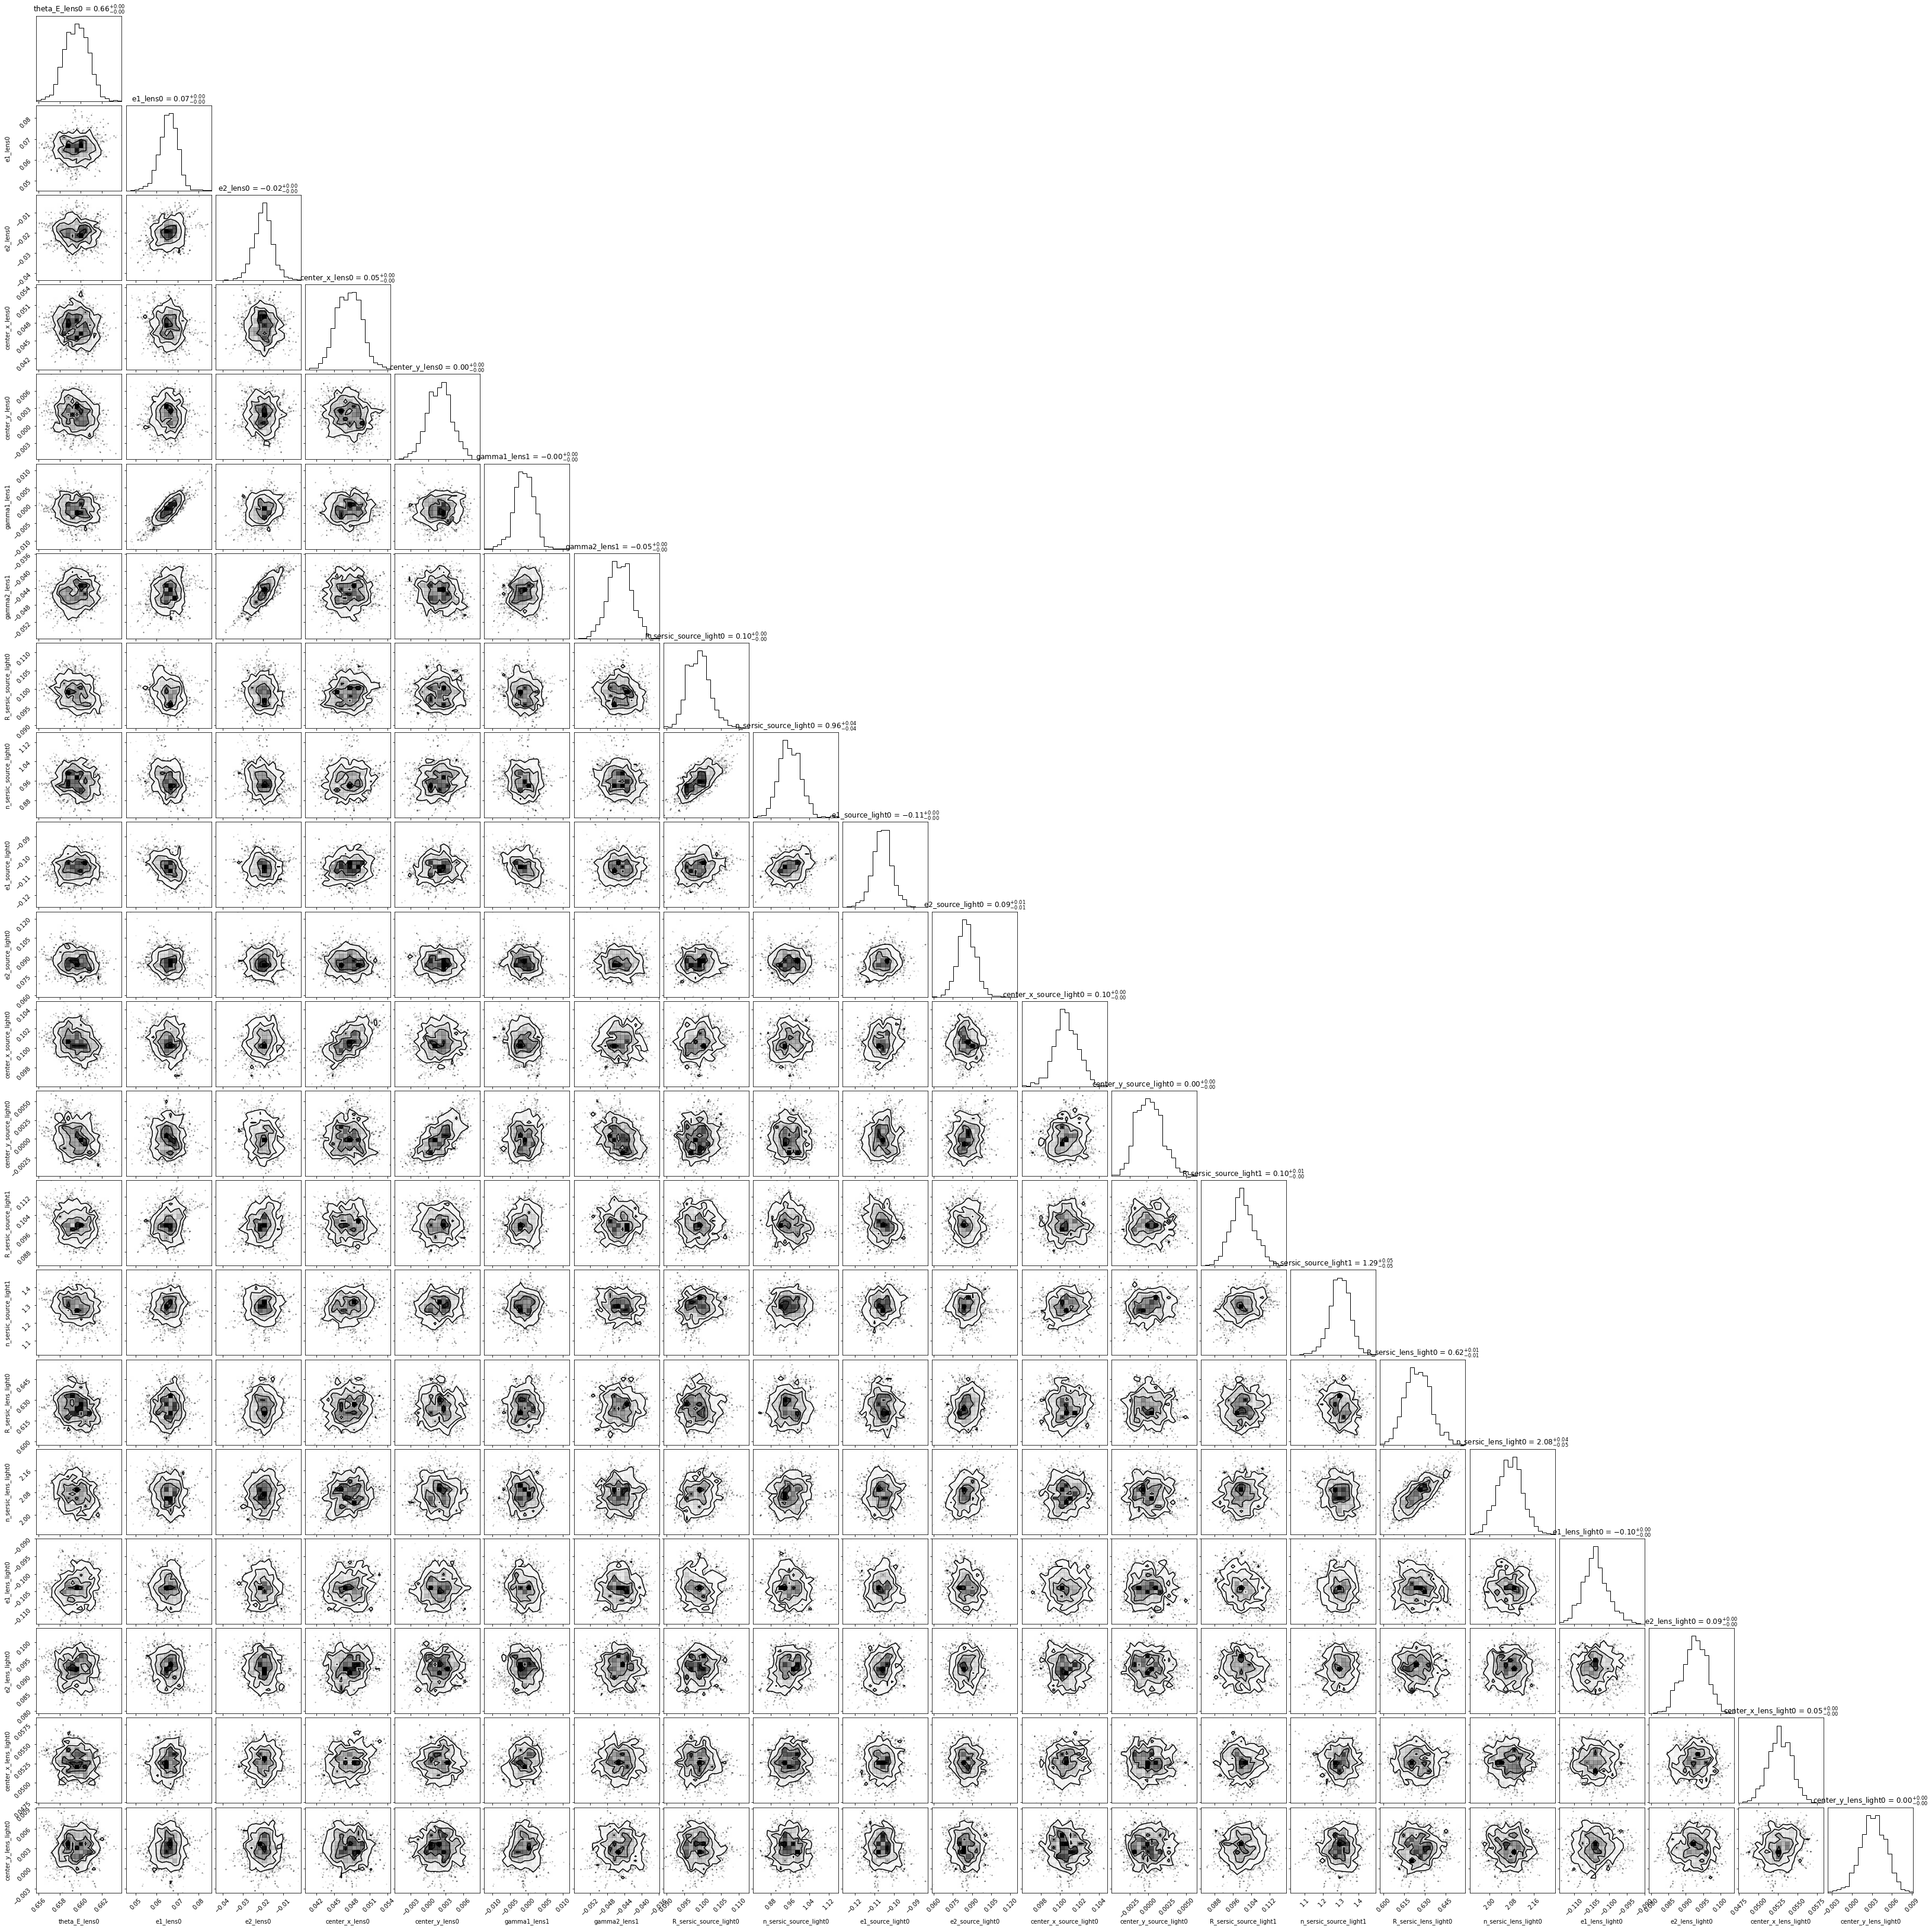

In [10]:
# the results of the MCMC chain

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[-1]

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)
